# Imputacion de datos

Tratar con datos faltantes implica que no siempre se pueden eliminar, sino que deben ser tratados con técnicas de imputación de datos
En este cuaderno se explorarán algunos casos empleando el dataset de diabetes, el cual contiene la información de pacientes a los cuales se les realizaron mediciones de la prueba de diabetes y pruebas en sangre. El dataset se puede descargar de: https://www.kaggle.com/datasets/mathchi/diabetes-data-set

In [3]:
#!pip install plotly
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler

In [4]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# cambiando nombres para facilitar la escritura del codigo
df.rename(columns ={"DiabetesPedigreeFunction":"DPF"},inplace=True)

In [6]:
# explorando los datos
df.describe([0.01, 0.05, 0.75, 0.90, 0.99]).T

,count,mean,std,min,1%,5%,50%,75%,90%,99%,max
Pregnancies,768.0,3.845052,3.369578,0.000,0.00000,0.00000,3.0000,6.00000,9.0000,13.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,57.00000,79.00000,117.0000,140.25000,167.0000,196.00000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,0.00000,38.70000,72.0000,80.00000,88.0000,106.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,0.00000,23.0000,32.00000,40.0000,51.33000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,0.00000,30.5000,127.25000,210.0000,519.90000,846.00
BMI,768.0,31.992578,7.884160,0.000,0.00000,21.80000,32.0000,36.60000,41.5000,50.75900,67.10
DPF,768.0,0.471876,0.331329,0.078,0.09468,0.14035,0.3725,0.62625,0.8786,1.69833,2.42
Age,768.0,33.240885,11.760232,21.000,21.00000,21.00000,29.0000,41.00000,51.0000,67.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.00000,0.0000,1.00000,1.0000,1.00000,1.00


In [7]:
# Para las columnas que no pueden ser cero, se reemplaza por NAN, con eso se elimina el sesgo que pueden introducir datos, por ejemplo, no tiene sentido que la presión de la sangre sea cero, o que el grosor de la piel sea cero, ni el índice de masa corporal
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [8]:
# Creando un gráfico de datos faltantes para conocer cuantos valores incompletos hay en el conjunto de datos
def missing_plot(dataset, key) :
    null_feat = pd.DataFrame(len(dataset[key]) - dataset.isnull().sum(), columns = ['Count'])
    percentage_null = pd.DataFrame((len(dataset[key]) - (len(dataset[key]) - dataset.isnull().sum()))/len(dataset[key])*100, columns = ['Count'])
    percentage_null = percentage_null.round(2)

    trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, text = percentage_null['Count'],  textposition = 'auto',marker=dict(color = '#7EC0EE',
            line=dict(color='#000000',width=1.5)))

    layout = dict(title =  "Missing Values (count & %)")

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

In [9]:
# Plotting
missing_plot(df, 'Outcome')

En el gráfico se logra apreciar que una característica muy importante para este conjunto de datos tiene cerca de la mitad de valores faltantes (la insulina).

In [10]:
# revisando los datos faltantes en forma de tabla (missing columns)
def missing_percent(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_table = pd.concat([mis_val, mis_percent], axis=1)

        # Rename the columns
        mis_columns = mis_table.rename(
        columns = {0 : 'Missing Values', 1 : 'Percent of Total Values'})

        # Sort the table by percentage of missing descending
        mis_columns = mis_columns[
            mis_columns.iloc[:,1] != 0].sort_values(
        'Percent of Total Values', ascending=False).round(2)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_columns

miss_cols_info = missing_percent(df)
miss_cols_info

Your selected dataframe has 9 columns.
There are 5 columns that have missing values.


,Missing Values,Percent of Total Values
Insulin,374,48.70
SkinThickness,227,29.56
BloodPressure,35,4.56
BMI,11,1.43
Glucose,5,0.65


In [11]:
# Las columnas con valores faltantes de más del 70% son eliminadas, se considera que en este caso los valores tienen tantas columnas faltantes que no se puede hacer nada con ellos.
 # se apliucarán diferentes operaciones de acuerdo a las proporciones de faltantes en el conjunto de datos. Por ejemplo, se quieren eliminar las variables independientes que tengan más del 25% de los datos faltantes.

df_drop = df.copy()
df_drop.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [12]:
# Eliminando columnas con mas del 25% de datos faltantes
drop_cols = miss_cols_info[miss_cols_info['Percent of Total Values'] > 25]
drop_cols
# En este caso se elimina la columna Insulina y grosor de la piel, ya que tienen muchos datos faltantes

,Missing Values,Percent of Total Values
Insulin,374,48.70
SkinThickness,227,29.56


In [13]:
col_names = drop_cols.index.tolist()
col_names
df_drop.drop(col_names, axis = 1, inplace=True)
df_drop.head()
print("Registros en el conjunto de datos original", df.shape)
print("Registros en el conjunto de datos", df_drop.shape)
# dataset con columnas eliminadas, en este caso se tiene el dataset sin esas dos características.

Registros en el conjunto de datos original (768, 9)
Registros en el conjunto de datos (768, 7)


In [14]:
# si bien, una forma de trabajar con los datos es eliminar las columnas con faltantes (eliminar las características)
# sin embargo se podría optar por un enfoque diferente y es eliminar los registros que tengan NaN en esas columnas, es decir, no enfocarnos en las filas sino en las columnas
df_drop_rows = df.copy() # otra copia del dataset para evitar dañar los datos ya cargados en memoria
df_drop_rows=df_drop_rows.dropna(subset=col_names) # eliminar NaNs en columnas inulina y ancho de piel
print("Registros en el conjunto de datos original", df.shape)
print("Registros en el conjunto de datos", df_drop_rows.shape)
df_drop_rows.head()
# en este caso se mantienen las 9 columnas, pero se borran 374 filas (casi la mitad del dataset)

Registros en el conjunto de datos original (768, 9)
Registros en el conjunto de datos (394, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
6,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
8,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1
13,1,189.0,60.0,23.0,846.0,30.1,0.398,59,1


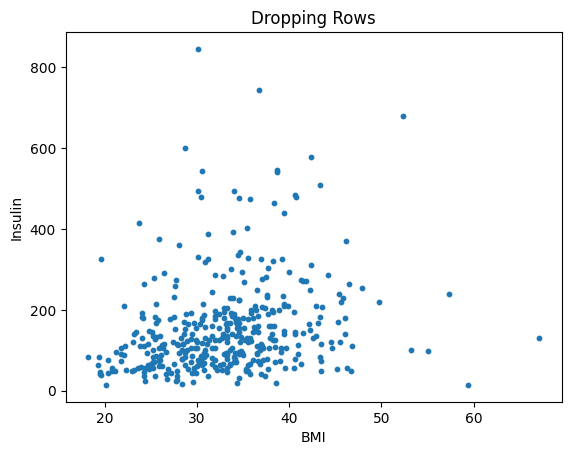

In [19]:
# Analyze visually with scatter plot
#plt.style.use('seaborn')
fig = plt.Figure()
fig = df_drop_rows.plot(x="BMI", y='Insulin', kind='scatter',
                    s = 10,
                    title='Dropping Rows', colorbar=False)



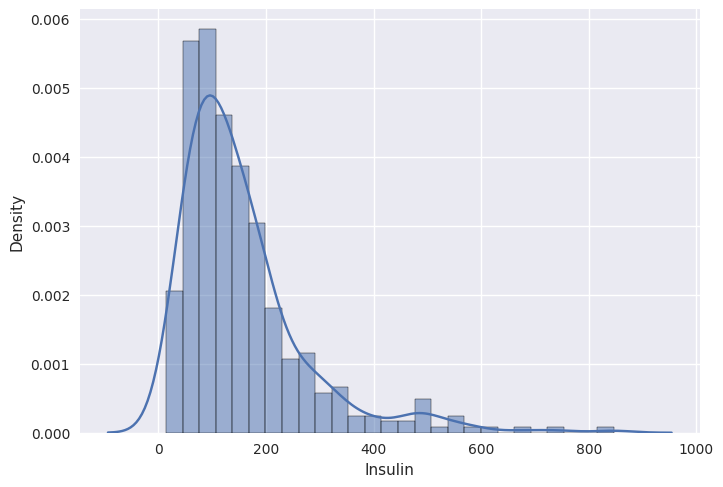

In [ ]:
sns.histplot(
    df_drop_rows["Insulin"], kde=True,
    stat="density", kde_kws=dict(cut=3)
)
sns.set_style("darkgrid")

The scikit-learn library provides a useful tool called the SimpleImputer function for addressing missing values in datasets. This function allows us to replace these missing values with a specified fill value. Within the SimpleImputer function, there exists a parameter known as strategy. This parameter offers four different options(mean(default), median, most_frequent and constant), each representing a distinct imputation method.

In [20]:
df_mean = df.copy()
round(df_mean['Insulin'].mean(), 2)


155.55

In [21]:
mean_imputer = SimpleImputer(missing_values = np.nan,strategy ='mean')
df_mean['Insulin'] = mean_imputer.fit_transform(
    df_mean['Insulin'].values.reshape(-1,1))

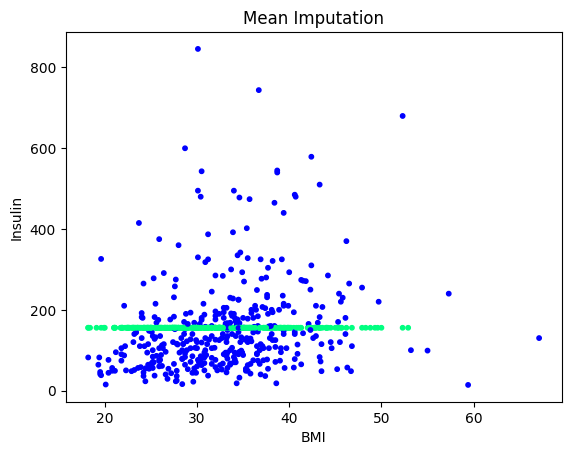

In [23]:
# Analyze visually with scatter plot
#plt.style.use('seaborn')
fig = plt.Figure()
null_values = df['Insulin'].isnull()
fig = df_mean.plot(x="BMI", y='Insulin', kind='scatter',
                     c=null_values, cmap='winter',s = 10,
                     title='Mean Imputation', colorbar=False)

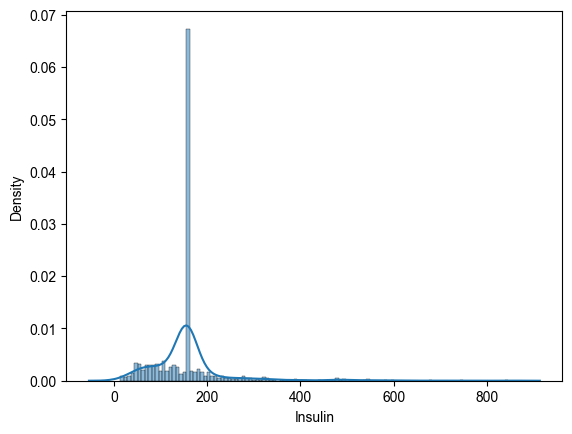

In [24]:


sns.histplot(
    df_mean["Insulin"], kde=True,
    stat="density", kde_kws=dict(cut=3)
)
sns.set_style("darkgrid")



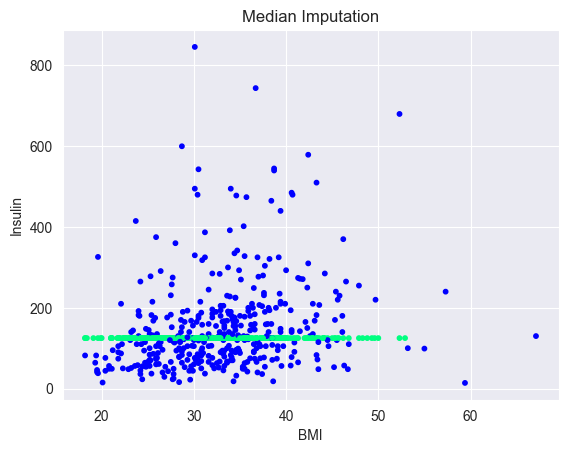

In [26]:

df_median = df.copy()
round(df_median['Insulin'].median(), 2)


#Median Imputation
median_imputer = SimpleImputer(missing_values = np.nan,
                        strategy ='median')
df_median['Insulin'] = median_imputer.fit_transform(
    df_median['Insulin'].values.reshape(-1,1))



# Analyze visually with scatter plot
#plt.style.use('seaborn')
fig = plt.Figure()
null_values = df['Insulin'].isnull()
fig = df_median.plot(x="BMI", y='Insulin', kind='scatter',
                     c=null_values, cmap='winter',s = 10,
                     title='Median Imputation', colorbar=False)





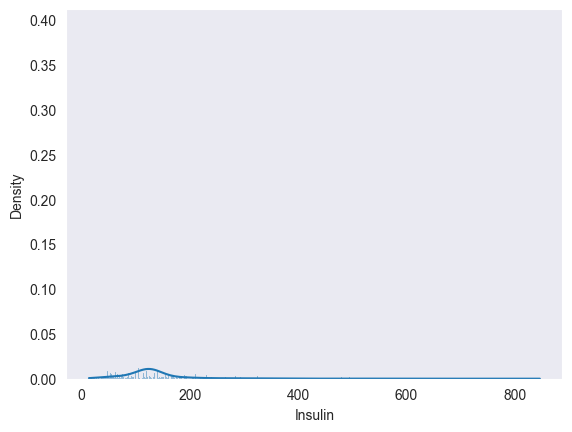

In [27]:
sns.histplot(
    df_median["Insulin"], kde=True,
    stat="density")
plt.grid()
sns.set_style("darkgrid")

Most of the imputation technique can cause bias. Simple imputation can result in an underestimation of standard errors. Simple imputed data for any statistic can lead to an underestimation of the standard error. As the number of missing data increases, simple imputation methods should be avoided.





<div style="color:white;display:fill;border-radius:8px;
            background-color:#2C3E50 ;font-size:110%;
            font-family:Helvetica;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>2.2) Advanced imputation methods</b></p>
</div>

One commonly adopted strategy for addressing missing data is to employ a predictive model to estimate the absent values. This technique entails developing a separate model for each input variable containing missing entries.

The default value of K is set to 5. Although there is no definitive method for determining the ideal value of K, a commonly used heuristic suggests that the optimal K is often the square root of the total number of samples in the dataset. Typically, an odd value is chosen for K to prevent ties in decision-making. To identify the most suitable K, an error plot or accuracy plot is commonly used.


In [28]:
df_knn = df.copy()
df_knn = df_knn.filter(['Pregnancies','Glucose','BloodPressure','BMI','DPF','Age','Insulin'], axis=1).copy()
df_knn.head()


scaler = MinMaxScaler(feature_range=(0, 1))
df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)

# Define KNN imputer and fill missing values
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)


df_knn_imputed.head()




,Pregnancies,Glucose,BloodPressure,BMI,DPF,Age,Insulin
0,0.352941,0.670968,0.489796,0.314928,0.234415,0.483333,0.287500
1,0.058824,0.264516,0.428571,0.171779,0.116567,0.166667,0.045192
2,0.470588,0.896774,0.408163,0.104294,0.253629,0.183333,0.275240
3,0.058824,0.290323,0.428571,0.202454,0.038002,0.000000,0.096154
4,0.000000,0.600000,0.163265,0.509202,0.943638,0.200000,0.185096


In [31]:


original_data = scaler.inverse_transform(df_knn_imputed)
# Convert the original data to a DataFrame
df_original = pd.DataFrame(original_data, columns=df_knn.columns)


df_original.head()




,Pregnancies,Glucose,BloodPressure,BMI,DPF,Age,Insulin
0,6.0,148.0,72.0,33.6,0.627,50.0,253.2
1,1.0,85.0,66.0,26.6,0.351,31.0,51.6
2,8.0,183.0,64.0,23.3,0.672,32.0,243.0
3,1.0,89.0,66.0,28.1,0.167,21.0,94.0
4,0.0,137.0,40.0,43.1,2.288,33.0,168.0


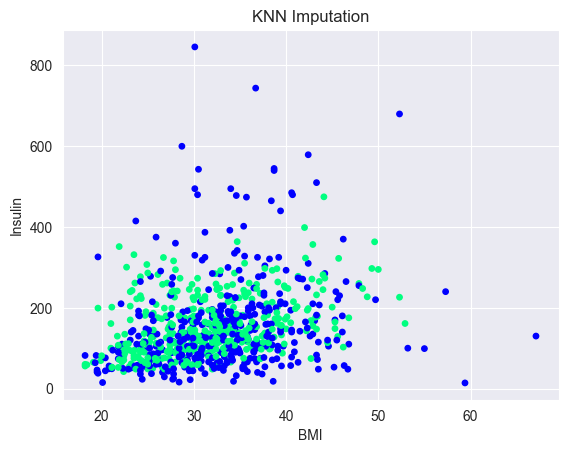

In [32]:
fig = plt.Figure()
null_values = df['Insulin'].isnull()
fig = df_original.plot(x='BMI', y='Insulin', kind='scatter',
                          c=null_values, cmap='winter', s = 15,
                          title='KNN Imputation', colorbar=False)

Text(0.5, 1.0, 'KNN Imputation')

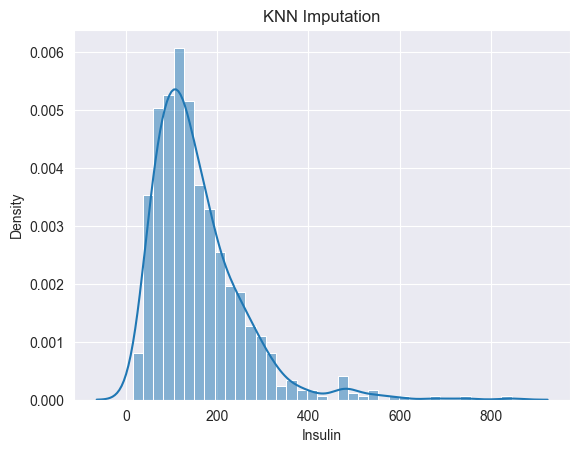

In [33]:
sns.histplot(
    df_original["Insulin"], kde=True,
    stat="density", kde_kws=dict(cut=3)
)
plt.title('KNN Imputation')

K-Nearest Neighbors (KNN) imputation tends to incur higher computational costs compared to simple imputation methods. However, it's important to note that KNN imputation remains effective for datasets that do not exceed the scale of tens of millions of records. However, as we can see from the scatterplots, knn seems to have completed the missing values in a way that does not distort a normal distribution.

MICE Imputation, short for 'Multiple Imputation by Chained Equation' is an advanced missing data imputation technique that uses multiple iterations of Machine Learning model training to predict the missing values using known values from other features in the data as predictors.
How does MICE algorithm work?

Here is a quick intuition (not the exact algorithm)

    You basically take the variable that contains missing values as a response 'Y' and other variables as predictors 'X'.
    Build a model with rows where Y is not missing.
    Then predict the missing observations. Do this multiple times by doing random draws of the data and taking the mean of the predictions

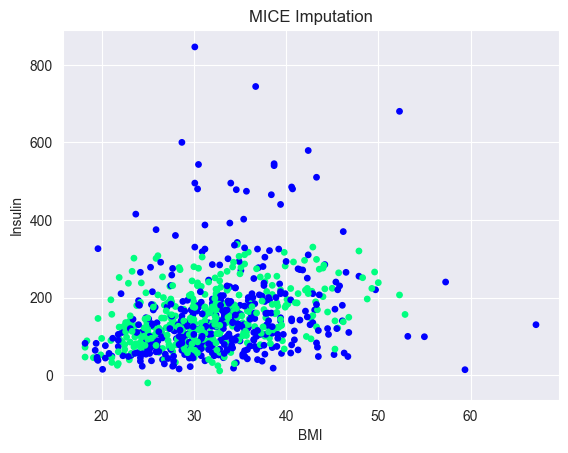

In [34]:
df_mice = df.copy()
df_mice = df.filter(['Pregnancies','Glucose','BloodPressure','BMI','DPF','Age','Insulin'], axis=1).copy()

# Define MICE Imputer and fill missing values
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)

fig = plt.Figure()
null_values = df['Insulin'].isnull()
fig = df_mice_imputed.plot(x='BMI', y='Insulin', kind='scatter',
                           c=null_values, cmap='winter', s = 15,
                           title='MICE Imputation', colorbar=False)



Text(0.5, 1.0, 'MICE Imputation')

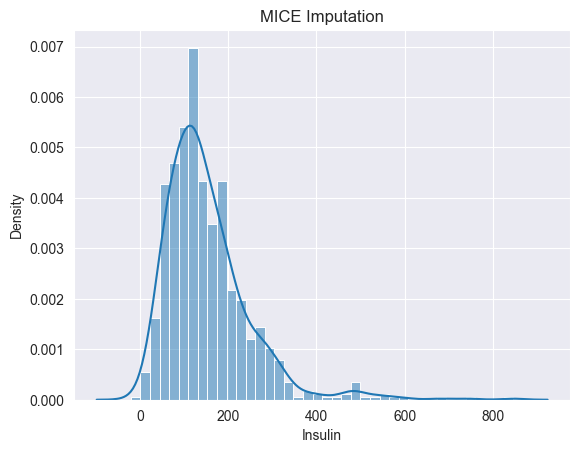

In [35]:
sns.histplot(
    df_mice_imputed["Insulin"], kde=True,
    stat="density", kde_kws=dict(cut=3)
)
plt.title('MICE Imputation')

In [36]:
# Comparacion de todos los métodos
drop_rows = pd.Series(df_drop_rows["Insulin"], name='drop_rows')
df_mean_ins = pd.Series(df_mean["Insulin"], name='Mean_Imp')
df_median_ins = pd.Series(df_median["Insulin"], name='Median_Imp')
df_knn_ins = pd.Series(df_original["Insulin"], name='KNN_Imp')
df_mice_ins = pd.Series(df_mice_imputed["Insulin"], name='MICE_Imp')

In [37]:
df_all = pd.concat([df_mean_ins,df_median_ins,df_knn_ins,df_mice_ins],axis=1)
df_all.head()

,Mean_Imp,Median_Imp,KNN_Imp,MICE_Imp
0,155.548223,125.0,253.2,218.788706
1,155.548223,125.0,51.6,68.765858
2,155.548223,125.0,243.0,267.615127
3,94.000000,94.0,94.0,94.000000
4,168.000000,168.0,168.0,168.000000


In [38]:


df_dropped = drop_rows.to_frame()
drop_desc = df_dropped.describe().loc[['mean', 'std']].T
drop_desc



,mean,std
drop_rows,155.548223,118.775855


In [39]:


drop_desc['std'][0]



C:\Users\Jeisson\AppData\Local\Temp\ipykernel_24988\2303693841.py:1: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



118.77585518724518

In [40]:
df_desc = df_all.describe().loc[['mean', 'std']].T
df_desc

,mean,std
Mean_Imp,155.548223,85.021108
Median_Imp,140.671875,86.383060
KNN_Imp,155.905208,99.481817
MICE_Imp,152.564749,97.431556


C:\Users\Jeisson\AppData\Local\Temp\ipykernel_24988\3220686398.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\Jeisson\AppData\Local\Temp\ipykernel_24988\3220686398.py:6: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



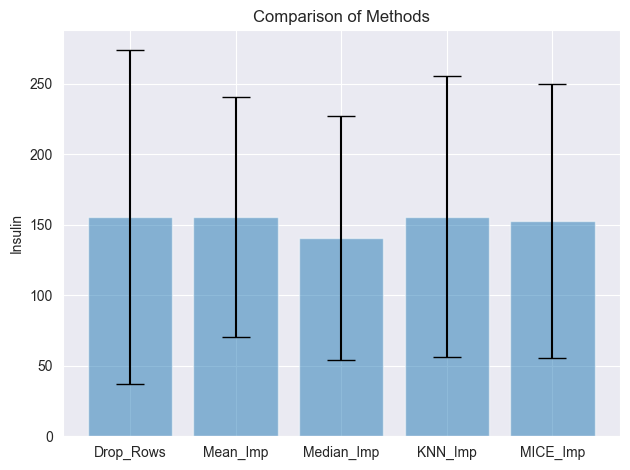

In [41]:

# error bars
# Define labels, positions, bar heights and error bar heights
labels = ['Drop_Rows','Mean_Imp', 'Median_Imp', 'KNN_Imp', 'MICE_Imp']
x_pos = np.arange(len(labels))
CTEs = [drop_desc['mean'][0],df_desc["mean"][0], df_desc["mean"][1], df_desc["mean"][2], df_desc["mean"][3]]
error = [drop_desc['std'][0],df_desc["std"][0], df_desc["std"][1], df_desc["std"][2], df_desc["std"][3]]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('Insulin')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Comparison of Methods')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()



    Removing missing data from the dataset seems to have increased the impact of outliers on std.

    In mean and median imputation methods, it increases the weight at a single point. This is why std is being suppressed and causing the range to get shorter.

    Knn and mice solve the problem of missing values without disturbing the normal distribution. In addition, mice seem less affected by outliers.

Conclusion¶

In this article, we analyze the results by applying different methods on how to deal with missing data. In the first stage, we identified missing data and analyzed the density in the data set visually and proportionally. We continued by coding how to deal with the detected missing data.

First, we analyzed the results using dropping and simple imputation methods. Mean and median imputation for a variable with a high proportion of missing data gives biased results. Or it distorts the correlation with other variables. But we chose to go a little deeper and collaborate with other variables in the dataset. In this way, we realized that instead of considering variables separately from the dataset, it is more accurate to solve this problem by considering all variables together.

Among the advanced imputation methods, we used KNN and MICE to fill in the missing data. The result gave a fairly accurate distribution compared to simple techniques.